# **Introduction**

In this tutorial we will implement an agent in a sequential decision making task using model-free and model-based approaches. To begin we will introduce the notion of contextual-bandits, which provide an intermediate step between the bandit problem we discussed in the previous tutorial and the full reinforcement learning problem.

# **Part I: Introduction**

**Contextual bandits:**

- Suppose there are several different k-armed bandit tasks, and that on each step you confront one of these chosen at random. Thus, the bandit task changes randomly from step to step. This would appear to you as a single, nonstationary k-armed bandit task whose true action values change randomly from step to step.
- Now suppose, that when a bandit task is selected, you are given some distinctive clue about its identity (but not its action values). Maybe you are facing an actual slot machine that changes the color of its display as it changes its action values. Now you can learn a policy associating each context with the best action to take when facing that context.
- This is an example of an associative search task and is often called contextual bandits.
- Learning value functions in these task requires the agent to maintain a representation of both the contexts (which we will refer to as a state) and the actions associated with them. 
- State-action value functions for contextual bandits are defined and updated in the same way as those in the bandit task.

**Definitions:**

State-action value function:

\begin{align}
q (s, a) = \mathbb{E} [r_{t} | s_{t} = s,a_{t} = a]
\end{align}

State-action value updates:

\begin{align}
q(s_{t}, a_{t}) \leftarrow q(s_{t}, a_{t}) + \alpha (r_{t} - q(s_{t}, a_{t}))
\end{align}

**Please run the following code for your implementation:**

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import copy

In [2]:
class world(object):
    def __init__(self):
        return

    def get_outcome(self):
        return
    
    def get_all_outcomes(self):
        
        outcomes = {}
        for state in range(self.n_states):
            for action in range(1 if self.n_actions == 0 else self.n_actions):
                next_state, reward = self.get_outcome(state, action)
                outcomes[state, action] = [(1, next_state, reward)]
        return outcomes

In [3]:
class drifting_probabilitic_bandit(world):
    """
    World: 2-Armed bandit.
    Each arm returns reward with a different probability.
    The probability of returning rewards for all arms follow Gaussian random walks.
    """
    
    def __init__(self, arm_number, drift):
        self.name = "n_armed_bandit"
        self.n_states = 1
        self.n_actions = arm_number
        self.dim_x = 1
        self.dim_y = 1
        
        self.mu_min = 0.25
        self.mu_max = 0.75
        self.drift = drift
        
        self.reward_mag = 1
        
        self.mu = [np.random.uniform(self.mu_min, self.mu_max) for a in range(self.n_actions)]
        
    def update_mu(self):
        self.mu += np.random.normal(0, self.drift, self.n_actions)
        self.mu[self.mu > self.mu_max] = self.mu_max
        self.mu[self.mu < self.mu_min] = self.mu_min
            
    def get_outcome(self, state, action):
        
        self.update_mu()
        self.rewards = [self.reward_mag if np.random.uniform(0,1) < self.mu[a] else 0 for a in range(self.n_actions) ]
        next_state = None
        
        reward = self.rewards[action]
        return int(next_state) if next_state is not None else None, reward

In [4]:
class contextual_bandits(drifting_probabilitic_bandit):
  
    def __init__(self):
        
        self.name = "contextual_bandit"
        self.n_states = 3
        self.n_actions = 2
        self.dim_x = 1
        self.dim_y = 1
        
        self.n_arms = self.n_actions
        self.n_of_bandits = self.n_states
        self.drift = 0.02
        self.bandits = [drifting_probabilitic_bandit(self.n_arms, self.drift) for n in range(self.n_of_bandits)]

    def get_outcome(self, state, action):
        
        _, reward = self.bandits[state].get_outcome(0,action)
        available_states = [s for s in range(self.n_of_bandits) if s != state]
        next_state = np.random.choice(available_states)
        
        return int(next_state) if next_state is not None else None, reward

In [5]:
def e_greedy_policy(q, epsilon):
    if np.random.uniform(0,1) > epsilon:
        return np.argmax(q)
    else:
        # choose randomly from all but the highest q value action
        a_list = np.arange(len(q))
        arg_max = np.argmax(q)
        choices = np.delete(a_list, arg_max)
        return np.random.choice(np.delete(a_list, arg_max))

# **Exercise 1:**

Train an agent to estimate the state-action value function for the contextual bandit task. The task has three contexts or states, each allows a two-arm bandit choice. On each step, the environment will provide a context and the agent is required to select an action. Select actions using an $\epsilon$-greedy policy. 

Plot performance curves for each of the bandits in each of the contexts.

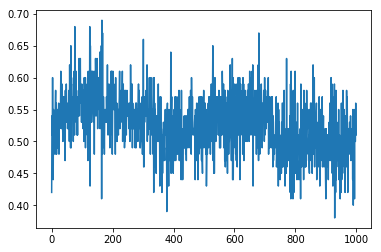

In [6]:
wrld = contextual_bandits()

n_trials = 100
n_steps = 1000
n_state = 3

alpha = 0.01
epsilon = 0.01

q = np.zeros((n_trials, n_steps, n_state, np.max(wrld.n_actions)))
chosen = np.zeros((n_trials, n_steps, n_state))
best_chosen = np.zeros((n_trials, n_steps))
state = np.zeros((n_trials, n_steps))



for i in range(n_trials):
    
    action = np.random.choice(np.arange(wrld.n_actions))
    
    for j in range(n_steps):
        
        next_state = None
        reward = None

        if j > 0:
            q[i, j, :, :] = q[i, j-1, :, :]
        next_state, reward = wrld.get_outcome(int(state[i, j]), action)

            
        q[i, j, int(state[i,j]),action] = (q[i,j,int(state[i,j]),action] 
                                        + alpha * (reward - q[i,j,int(state[i,j]),action]))

    
        chosen[i, j, int(state[i,j])] = action
        best_option = np.argmax(wrld.bandits[int(state[i,j])].mu)
        if action == best_option:
            best_chosen[i,j] = 1
        
        if j+1 < n_steps:
            state[i,j+1] = next_state
        action = e_greedy_policy(q[i,j,int(state[i,j]),:], epsilon)
        
plt.plot(np.mean(best_chosen, 0))

# **Part II: Introduction**

We will now extend the contextual bandit task to a sequential decision making task which provides a simple, yet very interesting environment that captures many aspects of the full reinforcement learning problem. The state-action value function in this case not only accounts for immediate rewards, but also future rewards. Also, actions in this environment allow the agent to influence the next state it encounters.

We will train an agent to solve this task using, both, model-free and model based strategies. For the model-free case, at each step the agent updates its estimate of its state-action value function using TD-learning. 

For the model-based case, on each step, we update a state transition matrix using a state-prediction error and an estimate of expected reward from each end state using the same update rule for the SARSA implementation. Finally, we explicitly compute the model-based state-action value function $Q_{MB}$ using the state transition matrix and expected rewards from the end states.



**Daw two-step task description:**
- The task is a two-stage Markov decision task in which, on each trial, an initial choice between two options probabilistically leads to either of two, second-stage ‘‘states’’.
- In turn, these second stage states demand another two-option choice, each of which is associated with a different chance of delivering a reward.
- The choice of one first-stage option leads predominantly (70% of the time) to one of the two second-stage states, and this relationship is fixed.
- The chances of payoff associated with the four second-stage options, however, change slowly and independently, according to Gaussian random walks.

**Definitions:**

For the general case, we define a state-action value function as:

\begin{align}
Q (s, a) = \mathbb{E} [r_{t} + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... | s_{t} = s,a_{t} = a]
\end{align}

\begin{align}
= \mathbb{E} [r_{t} + \gamma Q(s', a') | s_{t} = s,a_{t} = a]
\end{align}

State-action value updates (SARSA): 

\begin{align}
Q(s_{t}, a_{t}) \leftarrow Q(s_{t}, a_{t}) + \alpha (r_{t} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_{t}, a_{t}))
\end{align}

Soft-max policy:

\begin{align}
P(a_{t}|s_{t}) = \frac{ e^{\beta Q(s_{t}, a_{t})} }{ \sum_{b_{t}} e^{\beta Q(s_{t}, b_{t})} }
\end{align}

State transition matrix:

\begin{align}
T(s,a,s') = P(s_{t+1} = s' | s_{t} = s, a_{t} = a)
\end{align}

Model-based state-action value function:

\begin{align}
Q_{MB}(s,a) =  r_{t} + \sum_{s'} T(s,a,s') \: \text{max}_{a'} Q(s',a')
\end{align}

**Please run the following code for your implementation:**

In [7]:
class Daw_two_step_task(drifting_probabilitic_bandit):
  
    def __init__(self):
        
        self.name = "Daw_two_step_task"
        self.n_states = 3
        self.n_actions = 2
        self.dim_x = 1
        self.dim_y = 1
        
        self.n_arms = self.n_actions
        self.n_of_bandits = 2
        self.drift = 0.02
        
        self.context_transition_prob = 0.7
        self.bandits = [drifting_probabilitic_bandit(self.n_arms, self.drift) for n in range(self.n_of_bandits)]
        
    def get_outcome(self, state, action):
        
        if state == 0:
            reward = 0
            if action == 0:
                if np.random.uniform(0,1) < self.context_transition_prob:
                    next_state = 1
                else:
                    next_state = 2
            elif action == 1:
                if np.random.uniform(0,1) < self.context_transition_prob:
                    next_state = 2
                else:
                    next_state = 1
            else:
                print('No valid action specified')
                
        if state == 1:
            _, reward = self.bandits[0].get_outcome(0, action)
            next_state = 0
            
        if state == 2:
            _, reward = self.bandits[1].get_outcome(0, action)
            next_state = 0
        
        return int(next_state) if next_state is not None else None, reward

In [8]:
def softmax(state, q, beta):
    """
    Softmax policy: selects action probabilistically depending on the value.
    Args:
        state: an integer corresponding to the current state.
        q: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding to the action chosen according to the policy.
    """
    
    value = q[state,:]
    prob = exp(value * beta) # beta is the inverse temperature parameter
    prob = prob / sum(prob)  # normalize
    cum_prob = cumsum(prob)  # cummulation summation
    action = where(cum_prob > rand())[0][0]
    return action

# **Exercise 2:**

Implement the two-step task using a model-free strategy. To do so, train an agent on the above two-step task using SARSA updates. Run 3000 trials. Use a constant learning rate $\alpha = 0.2$ and a soft-max policy using an inverse temperature parameter of $\beta = 4$. 

1. For a single run, plot the reward probability associated with each of the second stage choices on each trial, the q-values learnt by the agent for all second state actions and the q-values of the two first stage actions.
2. Vary parameters $\alpha$ and $\beta$. How do these parameters influence the agent's estimates?
3. Each trial can be characterised by whether or not reward was received and whether the second-stage presented was common or rare given the first-stage choice. For each of these trial types, plot the probability of repeating the first-stage choice on the next trial.
4. How do the parameters $\alpha$ and $\beta$ affect the probabilities in (3)?

In [40]:
n_trials = 100
n_steps = 3000
n_bandits = 3
n_arms = 2



alpha = 0.8
beta = 4
gamma = 0.98

q = np.zeros((n_trials, n_steps, n_bandits, n_arms))
s = np.zeros((n_trials, n_steps), dtype=np.int)

# in the order: 
# reward-common, reward-uncommon, nonreward-common, nonreward-uncommon
# repeat, no repeat
history = np.zeros((4, 2))
pre_choice = np.zeros(4)

for i in range(n_trials):
    
    wrld = Daw_two_step_task()
    
    last_state = None
    last_action = None
    last_reward = None
    
    for j in range(n_steps):
        action = None
        reward = None
        if j == 0:
            action = softmax(s[i, j], np.zeros((n_bandits, n_arms)), beta)
        else:
            action = softmax(s[i, j], q[i, j, :, :], beta)
        next_state, reward = wrld.get_outcome(s[i, j], action)
        
        if s[i,j] != 0:
            is_reward = 1 if reward > 0 else 0
            is_common = 1 if (last_action == 0 and s[i,j]==1) or (last_action ==1 and s[i,j] == 2) else 0
            
            if is_reward and is_common:
                if pre_choice[0] == last_action:
                    history[0, 0] += 1
                history[0,1] += 1
                pre_choice[0] = last_action
            elif is_reward and (not is_common):
                if pre_choice[1] == last_action:
                    history[1, 0] += 1
                history[1,1] += 1
                pre_choice[1] = last_action
            elif (not is_reward) and is_common:
                if pre_choice[2] == last_action:
                    history[2, 0] += 1
                history[2,1] += 1
                pre_choice[2] = last_action
            elif (not is_reward) and (not is_common):
                if pre_choice[3] == last_action:
                    history[3, 0] += 1
                history[3,1] += 1
                pre_choice[3] = last_action
            
        
        if j > 0:
            q[i, j, last_state, last_action] = (q[i, j, last_state, last_action] 
                                       + alpha*(last_reward 
                                                + gamma*q[i,j,s[i,j], action] 
                                                -q[i,j,last_state,last_action]))
            
        
        if j < n_steps-1:
            s[i, j+1] = next_state
            
            q[i,j+1,:,:] = q[i,j,:,:]
            
        last_state = s[i,j]
        last_action = action
        last_reward = reward

            
        

<BarContainer object of 4 artists>

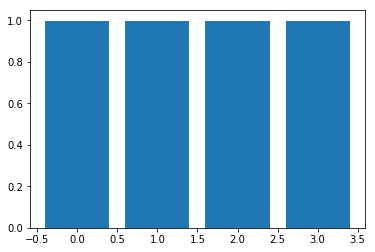

In [41]:
plt.bar(np.arange(4), history[:,0]/history[:,1])

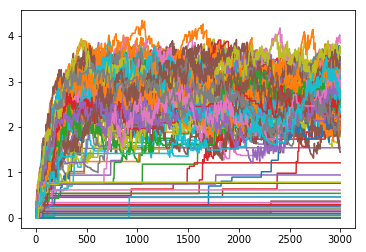

In [19]:
for i in range(n_trials):
    plt.plot(q[i, :, 1,0])
plt.show()



# **Exercise 3:**

We will now implement the two-step task using a model-based strategy. To do so, estimate a state transision matrix $T(s,a,s')$ and expected reward from each end state-action pair $Q(s,a)$. Initialise the transition matrix to have uniform probabilities of transitioning to all possible next states. Run 3000 trials. Use constant learning rates $\alpha = 0.2$ and a soft-max policy using an inverse temperature parameter of $\beta = 4$. 

1. Plot the expected reward from each of the second stage choices on each trial and the actual reward obtained by the agent.
2. Vary parameters $\alpha$ and $\beta$. How do these parameters influence the agent's performance?
3. For each of the four trial types discussed in the previous exercise, plot the probability of repeating the first-stage choice on the next trial when using a model-based strategy. 
4. How do the parameters $\alpha$ and $\beta$ affect the probabilities in (3)? 
5. How does the agent's performance using the model-based strategy compare with that using a model-free strategy? How do the stay probabilities differ when using a model-based vs model-free strategy?



In [ ]:
n_trials = 100
n_steps = 3000
n_bandits = 3
n_arms = 2

alpha = 0.2
beta = 4

q = np.zeros((n_trials, n_steps, n_bandits, n_arms))
s = np.zeros((n_trials, n_steps), dtype=np.int)

for i in range(n_trials):
    wrld = Daw_two_step_task()
    # transition matrix
    # 0-to-0, 0-to-1
    # 1-to-0, 1-to-1
    T = np.ones((2,2))*0.5
    T_n = np.zeros(2)
    
    last_action = None
    
    for j in range(n_steps):
        action = softmax(s[i, j], q[i, j, :, :], beta)
        next_state, reward = wrld.get_outcome(s[i, j], action)
        
        # update the transition matrix
        if s[i,j] > 0:
            second_stage_state = s[i,j]
            first_stage_action = last_action
            
            print(first_stage_action)
            if first_stage_action == 0:       
                T_n[0] = T_n[0] + 1
                
                
            elif first_stage_action == 1:
                T_n[1] = T_n[1] + 1
            
        

# **Exercise 4:**

We will now implement an agent that is a hybrid version of the model-free and model-based agents. Simultaneously train a model based and model free agent (as above). Run 5000 trials. Choose actions using a soft-max policy that uses a weighted combination of the model-based and model-free Q-values. Test for $w_{1} \in [0.3, 0.6]$ and $w_{2} = 1- w_{1}$.

1. Plot the expected reward from each of the second stage choices on each trial and the actual reward obtained by the agent.
2. For each of the four trial types discussed in the previous exercise, plot the probability of repeating the first-stage choice on the next trial when using the hybrid strategy.
3. Often, subjects are tested on this task and their stay probabilities are fit using such a hybrid model. The relative magnitude of the weights $w(1)$ and $w(2)$ is often taken to indicate how much they rely on model-based vs model-free strategies for behavioural control. Under what assumptions does this task allow us to do so? Hint: what components in your model simulation were required for you to be able to reproduce the profiles of stay-probabilities associated with model-based and model-free control?